# Dispersion statistique des résultats des candidats des élections provinciales 2022, par parti

Le code suivant calcule, pour chaque parti présent aux élections provinciales québécoises de 2022, le coefficient de Gini à partir des résultats de ses candidats dans chaque circonscription.

Ce coefficient, généralement utilisé en économie pour mesurer les inégalités de richesse, permet de mesurer la dispersion statistique des résultats entre candidats d'un parti. Un coefficient maximal de 1 indique qu'un seul candidat concentre tous les votes du parti (inégalité extrême), alors qu'un coefficient minimal de 0 indique que tous les votes sont répartis équitablement entre les candidats du parti (égalité parfaite).

Un graphique final permet de comparer les partis principaux (résultats nationaux > 1%) entre eux.

Un second graphique présente les partis secondaires (résultats nationaux < 1%). À noter que, sauf exception, aucun parti secondaire n'a présenté de candidat dans toutes les circonscriptions de la province. Afin de calculer des coefficients de Gini comparables entre eux à l'échelle de la province, l'absence de candidat pour un parti dans une circonscription est considérée comme un résultat de 0% pour ce parti.

## Charger les résultats

In [1]:
from urllib.request import urlopen
import json

url = "https://www.dgeq.org/doc/gen2022-10-03/resultats.json"

response = urlopen(url)
data = json.loads(response.read())

## Afficher la liste des partis
Avec leur numéro d'identification, triés par résultats décroissants

In [2]:
for parti in sorted(data['statistiques']['partisPolitiques'], key=lambda parti: parti['tauxVoteTotal'], reverse=True):
    print(f"[{parti['numeroPartiPolitique']}] {parti['nomPartiPolitique']}: {parti['tauxVoteTotal']:.2f}%")

[27] Coalition avenir Québec - L'équipe François Legault: 40.98%
[40] Québec solidaire: 15.43%
[8] Parti québécois: 14.61%
[6] Parti libéral du Québec/Quebec Liberal Party: 14.37%
[22] Parti conservateur du Québec - Équipe Éric Duhaime: 12.91%
[10] Parti vert du Québec/Green Party of Québec: 0.76%
[99263] Parti canadien du Québec / Canadian Party of Québec: 0.32%
[99237] Climat Québec: 0.21%
[99285] Bloc Montréal - Équipe Balarama Holness: 0.19%
[99286] Démocratie directe: 0.06%
[0] Candidats indépendants/Independent candidates: 0.05%
[23] Parti nul: 0.03%
[99275] L'union fait la force: 0.03%
[37] Parti 51: 0.02%
[7] Parti marxiste-léniniste du Québec: 0.02%
[29] Équipe autonomiste: 0.01%
[42] Parti culinaire du Québec: 0.01%
[99281] Parti humain du Québec: 0.01%
[99209] Union nationale: 0.00%
[99293] Alliance pour la famille et les communautés: 0.00%
[99291] Parti libertarien du Québec: 0.00%
[99236] Parti accès propriété et équité: 0.00%


### Configurer les couleurs des partis principaux (résultats > 1%):

In [3]:
couleurs = {
    27: '#00b4f1',
    40: '#ff5505',
    8: '#003eaa',
    6: '#ed1b2e',
    22: '#163b7a',
}

# Attribue une couleur à chaque parti principal (résultats > 1%)
for parti in data['statistiques']['partisPolitiques']:
    parti['couleur'] = couleurs.get(parti['numeroPartiPolitique'])

## Calcul de la dispersion des résultats

### Pour chaque parti, colliger une liste des résultats par circonscription

In [4]:
partis = {parti['numeroPartiPolitique']: parti for parti in data['statistiques']['partisPolitiques']}

for circo in data['circonscriptions']:
    for candidat in circo['candidats']:
        parti_id = candidat['numeroPartiPolitique']
        partis[parti_id].setdefault('resultats', []).append(candidat['tauxVote'])

### Calcul du coefficient de Gini

In [5]:
import numpy as np

# see https://www.statology.org/gini-coefficient-python/
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

In [6]:
nb_circos = data['statistiques']['nbCirconscription']

# Pour chaque parti...
for parti in partis.values():
    # Mettre le résultat à '0' dans les circonscriptions dans lesquelles le parti n'a aucun résultat (pas de candidat)
    parti['resultats'] += [0] * (nb_circos - len(parti['resultats']))
    # Calculer le coefficient de Gini sur les résultats
    parti['gini'] = gini(np.array(parti['resultats']))

### Présenter les résultats des partis principaux, triés du plus petit coefficient au plus grand:

In [7]:
from matplotlib import pyplot as plt

# Fonction pour afficher les coefficients de Gini pour chaque parti dans un graphique en barres horizontales
def display_plot(partis, titre=None, custom_colors=False):
    fig, ax = plt.subplots()
    if titre:
        fig.suptitle(titre, fontsize=16, x=0.25)
    partis_y = [parti['nomPartiPolitique'] for parti in partis]
    ginis = [parti['gini'] for parti in partis]
    
    y_pos = np.arange(len(partis))
    # Configure les ordonnées
    ax.invert_yaxis()
    ax.set_yticks(y_pos, labels=partis_y)
    # Configure les abscisses
    ax.set_xlim(left=0., right=1.)
    # Masque les bordures à droite et en haut
    ax.spines[['right', 'top']].set_visible(False)
    kwargs = {}
    if custom_colors:
        colors = [parti['couleur'] for parti in partis]
        kwargs['color'] = colors
    bars = ax.barh(y_pos, ginis, align='center', linewidth=11, **kwargs)
    # Ajoute les coefficients en labels dans les barres
    ax.bar_label(bars, fmt='{:,.2f}', label_type='center', color='white')
    plt.xlabel("← du plus égalitaire au moins égalitaire →", loc='center')
    plt.show()

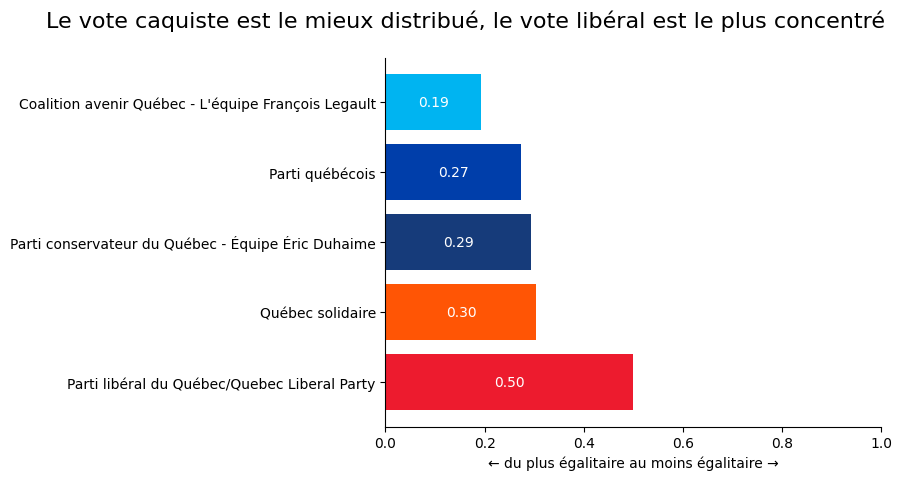

In [8]:
# Filtre les partis principaux (ceux auxquels nous avons attribuer une couleur)
partis_principaux = [parti for parti in partis.values() if parti.get('couleur') is not None]
# Trie par coefficient gini croissant
partis_principaux.sort(key=lambda x: x['gini'])

display_plot(partis_principaux, titre='Le vote caquiste est le mieux distribué, le vote libéral est le plus concentré', custom_colors=True)

### Présenter les résultats des partis secondaires

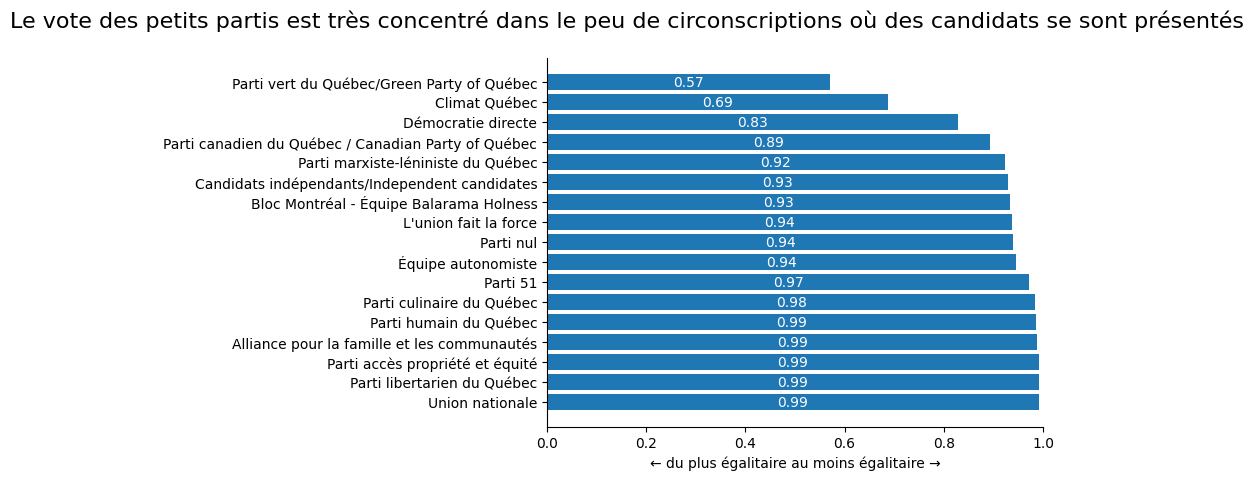

In [9]:
# Filtre les partis principaux (ceux auxquels nous avons attribuer une couleur)
partis_secondaires = [parti for parti in partis.values() if parti.get('couleur') is None]
# Trie par coefficient gini croissant
partis_secondaires.sort(key=lambda x: x['gini'])

display_plot(partis_secondaires, titre='Le vote des petits partis est très concentré dans le peu de circonscriptions où des candidats se sont présentés', )